# **Importação das Bibliotecas**

In [1]:
from typing import List, Tuple, Union, Dict, Any

import polars as pl
import numpy as np
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [2]:
sns.set_theme(style="whitegrid")

# **Definição das Funções**

In [3]:
def adjusted_barplot(data: pl.DataFrame, x: str, y: str, xlabel: str, ylabel: str, title: str, title_size: int=12,
                     legend: Union[None, str]=None, legend_labels: Union[None, Dict[Any, Any]]=None, legend_loc: str="best",
                     hue: Union[None, str]=None, palette: Union[None, str, List[str]]=None, color: Union[None, str]=None, 
                     figsize: Tuple[int]=(12,6), x_rotation: int=45, y_is_percent: bool=False, y_is_count: bool=False) -> None:
    """Plot adjusted bar chart.

    Args:
        data (pl.DataFrame): DataFrame with the data.
        x (str): x-axis column.
        y (str): y-axis column.
        xlabel (str): x-axis name.
        ylabel (str): y-axis name.
        title (str): Chart title.
        title_size (int, optional): Size of the chart title text. Defaults to 12.
        legend (Union[None, str], optional): Title of the legend. Defaults to None.
        legend_labels (Union[None, Dict[Any, Any]], optional): Custom labels for the legend. Defaults to None.
        legend_loc (str, optional): Legend location. Defaults to "best".
        hue (Union[None, str], optional): Name of the column that defines the color grouping for the bars. Defaults to None.
        palette (Union[None, str, List[str]], optional): Bar color palette (when hue is different from None). Defaults to None.
        color (Union[None, str], optional): Color of bars when hue is None. Defaults to None.
        figsize (Tuple[int], optional): Size of the figure (width, height). Defaults to (12,6).
        x_rotation (int): Rotation angle for x-axis labels. Defaults to 45.
        y_is_percent (bool, optional): Indicates whether y values ​​are percentages. Defaults to False.
        y_is_count (bool, optional): Indicates whether y values ​​are counts. Defaults to False.
    
    Returns:
        None
    """
    
    plt.figure(figsize=figsize)
    barplot = sns.barplot(data=data, x=x, y=y, hue=hue, palette=palette, color=color)
    plt.xticks(rotation=x_rotation)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if y_is_percent:
        barplot.yaxis.set_major_formatter(PercentFormatter(1.0))
    if legend:
        handles, _ = barplot.get_legend_handles_labels()
        if legend_labels:
            plt.legend(
                handles=handles, 
                labels=[legend_labels[col] for col in data[hue].unique(maintain_order=True)], 
                title=legend,
                loc=legend_loc
            )
        else:    
            plt.legend(handles=handles, title=legend, loc=legend_loc)
    plt.title(title, fontsize=title_size)

    for p in barplot.patches:
        height = p.get_height()
        aux = 8 if height >= 0 else -8
        text = f"{height:.2%}" if y_is_percent else f"{height:.0f}" if y_is_count else f"{height:.2f}"
        
        if 0.0 not in data[y]:
            if height:
                barplot.annotate(
                    text,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha="center", 
                    va="center",
                    xytext=(0, aux),
                    textcoords="offset points",
                    color=p.get_facecolor()
                )
        else:
            barplot.annotate(
                text,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", 
                va="center",
                xytext=(0, aux),
                textcoords="offset points",
                color=p.get_facecolor()
            )

    plt.show()

In [4]:
def get_palette_color(palette: str, color: str) -> str:
    """Get color from chosen palette.

    Args:
        palette (str): Palette name.
        color (str): Color name.

    Raises:
        KeyError: Palette or Color not found.

    Returns:
        str: Hexadecimal color code.
    
    Palette options: pastel, muted, bright, colorblind, deep, dark.
    Color options: blue, orange, green, red, purple, brown, pink, gray, yellow, light blue.
    """
    
    try:
        chosen_palette = sns.color_palette(palette)
    except:
        raise KeyError(
            "Paleta não encontrada; Escolha entre ['pastel', 'muted', 'bright', 'colorblind', 'deep', 'dark']"
        )
        
    colors_dict = {
        "blue": chosen_palette[0],
        "orange": chosen_palette[1],
        "green": chosen_palette[2],
        "red": chosen_palette[3],
        "purple": chosen_palette[4],
        "brown": chosen_palette[5],
        "pink": chosen_palette[6],
        "gray": chosen_palette[7],
        "yellow": chosen_palette[8],
        "light blue": chosen_palette[9]
    }
    
    try:
        return colors_dict[color]
    except:
        raise KeyError(
            "Cor não encontrada; Escolha entre ['blue', 'orange', 'green', 'red', 'purple', brown', 'pink', 'grey', 'yellow', 'light blue']"
        )

# **Base de dados 1: Store Item Demand**

- Tempo total de execução (12 núcleos com paralelismo): 
    - **Frequência Diária:** 100 séries -> 2 horas e 1.83 segundos
    - **Frequência Semanal:** 100 séries -> 33 minutos e 9.42 segundos

## **Leitura dos Dados**

In [5]:
with open("../conf/base/parameters.yml", "r") as file:
    parameters = yaml.safe_load(file)

In [6]:
daily_results = pl.read_parquet("../data/08_reporting/RESULTS_STORE_ITEM_DAILY.pq")
daily_results.describe()

statistic,unique_id,store,item,transformation,model,execution_time,smape,rmsle,owa
str,str,str,str,str,str,f64,f64,f64,f64
"""count""","""800""","""800""","""800""","""800""","""800""",800.0,800.0,800.0,800.0
"""null_count""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0
"""mean""",null,null,null,null,null,104.051629,0.183328,0.223041,0.897727
"""std""",null,null,null,null,null,134.259733,0.036017,0.043621,0.166179
"""min""","""01_04""","""01""","""01""","""log""","""ARIMA""",0.093747,0.069531,0.090424,0.345956
"""25%""",null,null,null,null,null,10.814851,0.164985,0.200844,0.804056
"""50%""",null,null,null,null,null,68.330094,0.184487,0.224837,0.919266
"""75%""",null,null,null,null,null,129.059495,0.205686,0.251367,1.002988
"""max""","""10_47""","""10""","""50""","""original""","""XGBoost""",577.360054,0.284169,0.338092,1.351589


In [7]:
weekly_results = pl.read_parquet("../data/08_reporting/RESULTS_STORE_ITEM_WEEKLY.pq")
weekly_results.describe()

statistic,unique_id,store,item,transformation,model,execution_time,smape,rmsle,owa
str,str,str,str,str,str,f64,f64,f64,f64
"""count""","""800""","""800""","""800""","""800""","""800""",800.0,800.0,800.0,800.0
"""null_count""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0
"""mean""",null,null,null,null,null,28.438405,0.096698,0.109352,1.071448
"""std""",null,null,null,null,null,24.154193,0.053274,0.061943,0.744741
"""min""","""01_04""","""01""","""01""","""log""","""ARIMA""",0.124998,0.030315,0.034149,0.343412
"""25%""",null,null,null,null,null,6.267187,0.061379,0.072113,0.758121
"""50%""",null,null,null,null,null,20.089967,0.092344,0.103557,0.930496
"""75%""",null,null,null,null,null,44.820771,0.114667,0.127173,1.122029
"""max""","""10_47""","""10""","""50""","""original""","""XGBoost""",108.739925,0.601753,0.790646,11.391973


## **Análises**

In [8]:
metrics = parameters.get("METRICS")
key_metric = parameters.get("KEY_METRIC")
analysis_cols = ["execution_time"] + metrics
frequencies = ["daily", "weekly"]

### **Valores infinitos (erros)**

In [9]:
daily_results.filter(
    pl.fold(
        acc=pl.lit(False),
        function=lambda acc, x: acc | x,
        exprs=[pl.col(col) == np.inf for col in metrics]
    )
)

unique_id,store,item,transformation,model,execution_time,smape,rmsle,owa
str,str,str,str,str,f64,f64,f64,f64


In [10]:
weekly_results.filter(
    pl.fold(
        acc=pl.lit(False),
        function=lambda acc, x: acc | x,
        exprs=[pl.col(col) == np.inf for col in metrics]
    )
)

unique_id,store,item,transformation,model,execution_time,smape,rmsle,owa
str,str,str,str,str,f64,f64,f64,f64


- Nenhum erro ocorreu durante o treinamento de qualquer modelo/unique_id.

### **Criação das variáveis para análises**

In [11]:
# Loop pelos diferentes valores de frequência em 'frequencies'
for frequency in frequencies:
    globals()[f"{frequency}_analysis"] = (
        globals()[f"{frequency}_results"]
        .group_by("model")
        .agg(
            *[pl.col(col).mean().round(4).alias(f"{col}_mean") for col in analysis_cols],
            *[pl.col(col).median().round(4).alias(f"{col}_median") for col in analysis_cols]
        )
    )
    
    globals()[f"{frequency}_ordered_time"] = (
        globals()[f"{frequency}_analysis"]
        .sort("execution_time_mean")
        .melt(
            id_vars="model", 
            value_vars=["execution_time_mean", "execution_time_median"], 
            variable_name="execution_time", 
            value_name="value"
        )
    )

In [12]:
# Criação das variáveis de comparação das métricas por frequência e por medida dinamicamente
for frequency in frequencies:    
    for measure in ["mean", "median"]:   
        globals()[f"{frequency}_metrics_{measure}"] = (
            globals()[f"{frequency}_analysis"]
            .sort(f"{key_metric}_{measure}")
            .melt(
                id_vars="model", 
                value_vars=[f"{metric}_{measure}" for metric in metrics], 
                variable_name=f"metric_{measure}", 
                value_name="value"
            )
        )

In [13]:
# Criação das variáveis do tempo de execução e de cada métrica dinamicamente para comparação
for col in analysis_cols:
    globals()[f"{col}_comparison"] = (
        globals()["daily_analysis"]
        .join(globals()["weekly_analysis"], on="model", how="inner")
        .rename(
            {
                f"{col}_mean": f"daily_{col}_mean",
                f"{col}_mean_right": f"weekly_{col}_mean",
            } 
        )
        .select(["model", f"daily_{col}_mean", f"weekly_{col}_mean"])
    )
    
    globals()[f"ordered_{col}"] = (
        globals()[f"{col}_comparison"]
        .sort(f"daily_{col}_mean")
        .melt(
            id_vars="model", 
            value_vars=[f"daily_{col}_mean", f"weekly_{col}_mean"], 
            variable_name=col, 
            value_name="value"
        )   
    )  

    globals()[f"{col}_comparison"] = (
        globals()[f"{col}_comparison"]
        .with_columns(
            reduction_percent=(
                (
                    (globals()[f"{col}_comparison"][f"daily_{col}_mean"] - globals()[f"{col}_comparison"][f"weekly_{col}_mean"]) \
                        / globals()[f"{col}_comparison"][f"daily_{col}_mean"]
                ) * -1  # Para indicar redução
            )
            .round(4)
        )
    )

In [14]:
globals()[f"daily_analysis"].sort("model")  # Frequência Diária

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""ARIMA""",36.3228,0.1839,0.2243,0.8997,33.9168,0.1794,0.2168,0.9089
"""ExponentialSmo…",37.2966,0.1881,0.2285,0.9193,25.2986,0.186,0.2262,0.9198
"""FourTheta""",6.6134,0.18,0.2157,0.8758,6.6046,0.1781,0.209,0.8812
"""N-HiTS""",180.5167,0.1935,0.2358,0.9491,178.5881,0.1921,0.2344,0.9339
"""Prophet""",78.8674,0.2002,0.2429,0.9622,77.3804,0.1964,0.2384,0.9789
"""SimpleMovingAv…",0.2799,0.1951,0.2346,0.9654,0.2128,0.1905,0.2289,0.969
"""TiDE""",414.7429,0.2037,0.252,1.0133,436.7269,0.1969,0.2458,1.0156
"""XGBoost""",77.7734,0.1221,0.1506,0.5969,77.4641,0.1152,0.1427,0.5933


In [15]:
globals()[f"weekly_analysis"].sort("model")  # Frequência Semanal

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""ARIMA""",14.455,0.0947,0.1054,0.9221,14.1564,0.0912,0.1014,0.919
"""ExponentialSmo…",8.6754,0.0646,0.0748,0.7674,8.0827,0.0587,0.0679,0.724
"""FourTheta""",4.4577,0.06,0.0703,0.7247,4.4808,0.0525,0.0625,0.7077
"""N-HiTS""",41.9614,0.183,0.207,2.2514,42.2498,0.1558,0.1736,1.909
"""Prophet""",40.8852,0.0942,0.1064,0.9414,39.4349,0.0908,0.1032,0.9424
"""SimpleMovingAv…",0.2245,0.1163,0.1255,1.0886,0.1954,0.1152,0.1238,1.0639
"""TiDE""",69.0133,0.1052,0.1202,1.1938,68.0801,0.1038,0.1187,1.165
"""XGBoost""",47.8347,0.0557,0.0652,0.6821,47.1288,0.0538,0.0623,0.6618


### **Tempo de execução**

#### **Frequência Diária**

In [16]:
globals()[f"daily_analysis"].sort("execution_time_mean")

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""SimpleMovingAv…",0.2799,0.1951,0.2346,0.9654,0.2128,0.1905,0.2289,0.969
"""FourTheta""",6.6134,0.18,0.2157,0.8758,6.6046,0.1781,0.209,0.8812
"""ARIMA""",36.3228,0.1839,0.2243,0.8997,33.9168,0.1794,0.2168,0.9089
"""ExponentialSmo…",37.2966,0.1881,0.2285,0.9193,25.2986,0.186,0.2262,0.9198
"""XGBoost""",77.7734,0.1221,0.1506,0.5969,77.4641,0.1152,0.1427,0.5933
"""Prophet""",78.8674,0.2002,0.2429,0.9622,77.3804,0.1964,0.2384,0.9789
"""N-HiTS""",180.5167,0.1935,0.2358,0.9491,178.5881,0.1921,0.2344,0.9339
"""TiDE""",414.7429,0.2037,0.252,1.0133,436.7269,0.1969,0.2458,1.0156


In [17]:
globals()[f"daily_ordered_time"]

model,execution_time,value
str,str,f64
"""SimpleMovingAv…","""execution_time…",0.2799
"""FourTheta""","""execution_time…",6.6134
"""ARIMA""","""execution_time…",36.3228
"""ExponentialSmo…","""execution_time…",37.2966
"""XGBoost""","""execution_time…",77.7734
…,…,…
"""ExponentialSmo…","""execution_time…",25.2986
"""XGBoost""","""execution_time…",77.4641
"""Prophet""","""execution_time…",77.3804


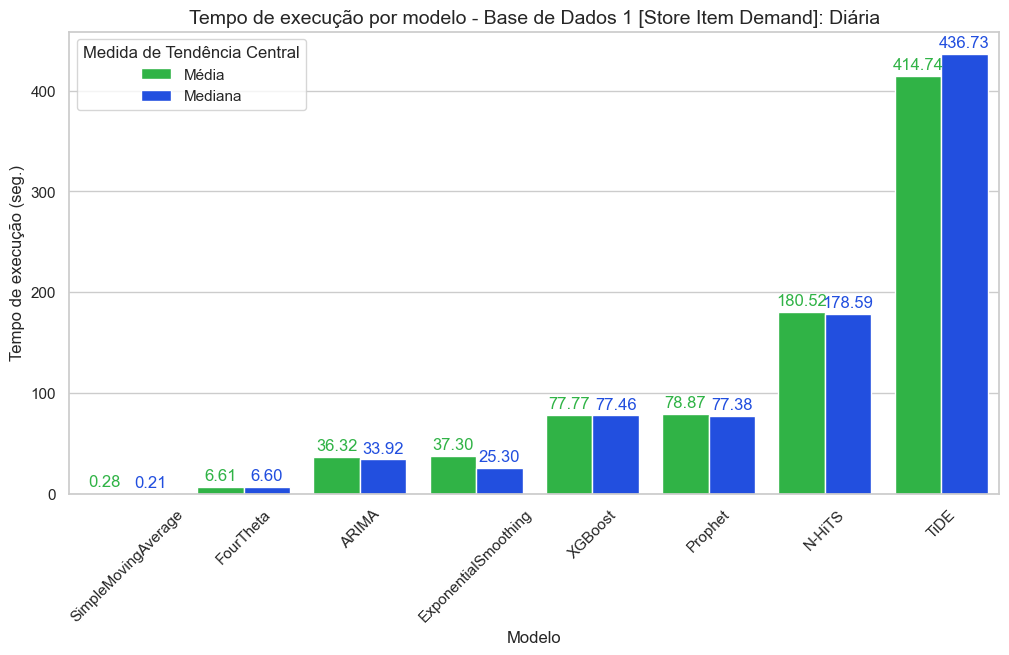

In [18]:
palette = sns.color_palette(
    [
        get_palette_color(palette="bright", color="green"),
        get_palette_color(palette="bright", color="blue")
    ]
)

legend_labels = {
    "execution_time_mean": "Média", 
    "execution_time_median": "Mediana"
}

adjusted_barplot(
    data=globals()[f"daily_ordered_time"], x="model", y="value", hue="execution_time", palette=palette,
    xlabel="Modelo", ylabel="Tempo de execução (seg.)", legend="Medida de Tendência Central", title_size=14,
    legend_labels=legend_labels, title="Tempo de execução por modelo - Base de Dados 1 [Store Item Demand]: Diária"
)

- Os resultados das médias e medianas foram bastante semelhantes, indicando a ausência de muitos outliers no tempo de execução;

- O *TiDE* se destacou como o modelo mais lento, com um tempo de execução médio de 414,74 segundos, enquanto o *Simple Moving Average* (*S.M.A.*) foi o mais rápido, com um tempo de execução médio de 0,28 segundos.

#### **Frequência Semanal**

In [19]:
globals()[f"weekly_analysis"].sort("execution_time_mean")

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""SimpleMovingAv…",0.2245,0.1163,0.1255,1.0886,0.1954,0.1152,0.1238,1.0639
"""FourTheta""",4.4577,0.06,0.0703,0.7247,4.4808,0.0525,0.0625,0.7077
"""ExponentialSmo…",8.6754,0.0646,0.0748,0.7674,8.0827,0.0587,0.0679,0.724
"""ARIMA""",14.455,0.0947,0.1054,0.9221,14.1564,0.0912,0.1014,0.919
"""Prophet""",40.8852,0.0942,0.1064,0.9414,39.4349,0.0908,0.1032,0.9424
"""N-HiTS""",41.9614,0.183,0.207,2.2514,42.2498,0.1558,0.1736,1.909
"""XGBoost""",47.8347,0.0557,0.0652,0.6821,47.1288,0.0538,0.0623,0.6618
"""TiDE""",69.0133,0.1052,0.1202,1.1938,68.0801,0.1038,0.1187,1.165


In [20]:
globals()["weekly_ordered_time"]

model,execution_time,value
str,str,f64
"""SimpleMovingAv…","""execution_time…",0.2245
"""FourTheta""","""execution_time…",4.4577
"""ExponentialSmo…","""execution_time…",8.6754
"""ARIMA""","""execution_time…",14.455
"""Prophet""","""execution_time…",40.8852
…,…,…
"""ARIMA""","""execution_time…",14.1564
"""Prophet""","""execution_time…",39.4349
"""N-HiTS""","""execution_time…",42.2498


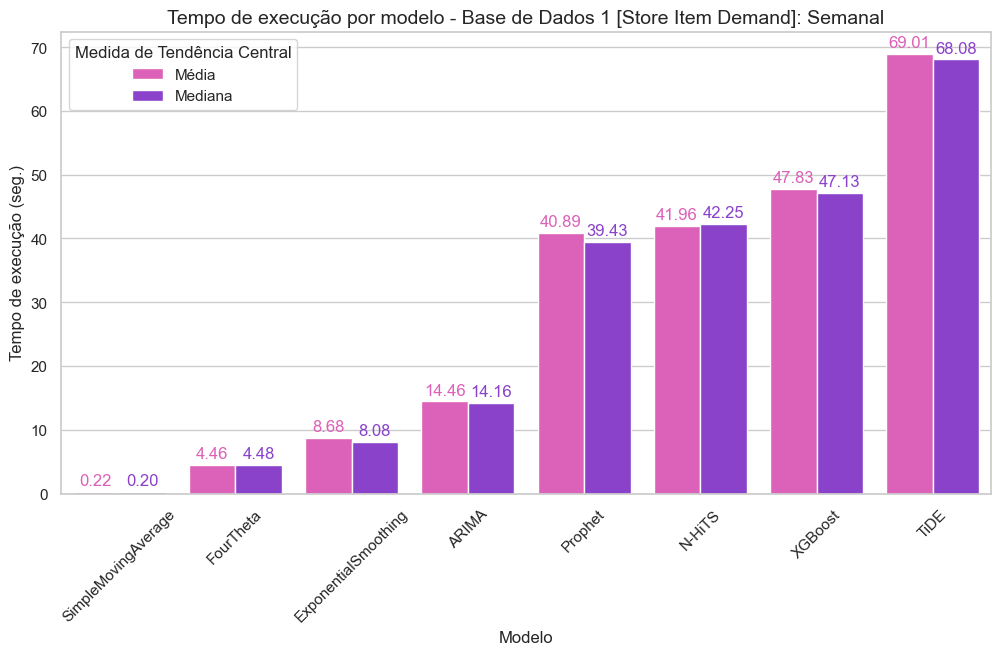

In [21]:
palette = sns.color_palette(
    [
        get_palette_color(palette="bright", color="pink"),
        get_palette_color(palette="bright", color="purple")
    ]
)

legend_labels = {
    "execution_time_mean": "Média", 
    "execution_time_median": "Mediana"
}

adjusted_barplot(
    data=globals()["weekly_ordered_time"], x="model", y="value", hue="execution_time", palette=palette,
    xlabel="Modelo", ylabel="Tempo de execução (seg.)", legend="Medida de Tendência Central", title_size=14,
    legend_labels=legend_labels, title="Tempo de execução por modelo - Base de Dados 1 [Store Item Demand]: Semanal"
)

- Assim como na "Frequência Diária", os resultados das médias e medianas foram bastante semelhantes, indicando a ausência de muitos outliers no tempo de execução;

- Novamente, o *TiDE* se destacou como o modelo mais lento, dessa vez com um tempo de execução médio de 69,01 segundos, enquanto o *Simple Moving Average* (*S.M.A.*) foi o mais rápido, com um tempo de execução médio de 0,22 segundos.

### **Métricas**

#### **Interpretação da OWA (Métrica Principal)**

- OWA < 1: O modelo está performando melhor do que o modelo *Naive*. Isso significa que as previsões são mais precisas em termos das métricas sMAPE e RMSLE em comparação com as previsões do modelo *Naive*.

- OWA = 1: O modelo tem a mesma performance que o modelo *Naive*. Isso indica que as previsões não são melhores nem piores que as do modelo *Naive*.

- OWA > 1: O modelo está performando pior do que o modelo *Naive*. Isso significa que as previsões são menos precisas em termos das métricas sMAPE e RMSLE em comparação com as previsões do modelo *Naive*.

**Exemplos:**

- Se a OWA for 0.8, isso indica que, em média, o modelo é 20% melhor do que o modelo *Naive*.

- Se a OWA for 1.2, isso indica que, em média, o modelo é 20% pior do que o modelo *Naive*.

#### **Frequência Diária**

In [22]:
globals()["daily_analysis"].sort(f"{key_metric}_mean")

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""XGBoost""",77.7734,0.1221,0.1506,0.5969,77.4641,0.1152,0.1427,0.5933
"""FourTheta""",6.6134,0.18,0.2157,0.8758,6.6046,0.1781,0.209,0.8812
"""ARIMA""",36.3228,0.1839,0.2243,0.8997,33.9168,0.1794,0.2168,0.9089
"""ExponentialSmo…",37.2966,0.1881,0.2285,0.9193,25.2986,0.186,0.2262,0.9198
"""N-HiTS""",180.5167,0.1935,0.2358,0.9491,178.5881,0.1921,0.2344,0.9339
"""Prophet""",78.8674,0.2002,0.2429,0.9622,77.3804,0.1964,0.2384,0.9789
"""SimpleMovingAv…",0.2799,0.1951,0.2346,0.9654,0.2128,0.1905,0.2289,0.969
"""TiDE""",414.7429,0.2037,0.252,1.0133,436.7269,0.1969,0.2458,1.0156


In [23]:
globals()["daily_analysis"].sort(f"{key_metric}_median")

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""XGBoost""",77.7734,0.1221,0.1506,0.5969,77.4641,0.1152,0.1427,0.5933
"""FourTheta""",6.6134,0.18,0.2157,0.8758,6.6046,0.1781,0.209,0.8812
"""ARIMA""",36.3228,0.1839,0.2243,0.8997,33.9168,0.1794,0.2168,0.9089
"""ExponentialSmo…",37.2966,0.1881,0.2285,0.9193,25.2986,0.186,0.2262,0.9198
"""N-HiTS""",180.5167,0.1935,0.2358,0.9491,178.5881,0.1921,0.2344,0.9339
"""SimpleMovingAv…",0.2799,0.1951,0.2346,0.9654,0.2128,0.1905,0.2289,0.969
"""Prophet""",78.8674,0.2002,0.2429,0.9622,77.3804,0.1964,0.2384,0.9789
"""TiDE""",414.7429,0.2037,0.252,1.0133,436.7269,0.1969,0.2458,1.0156


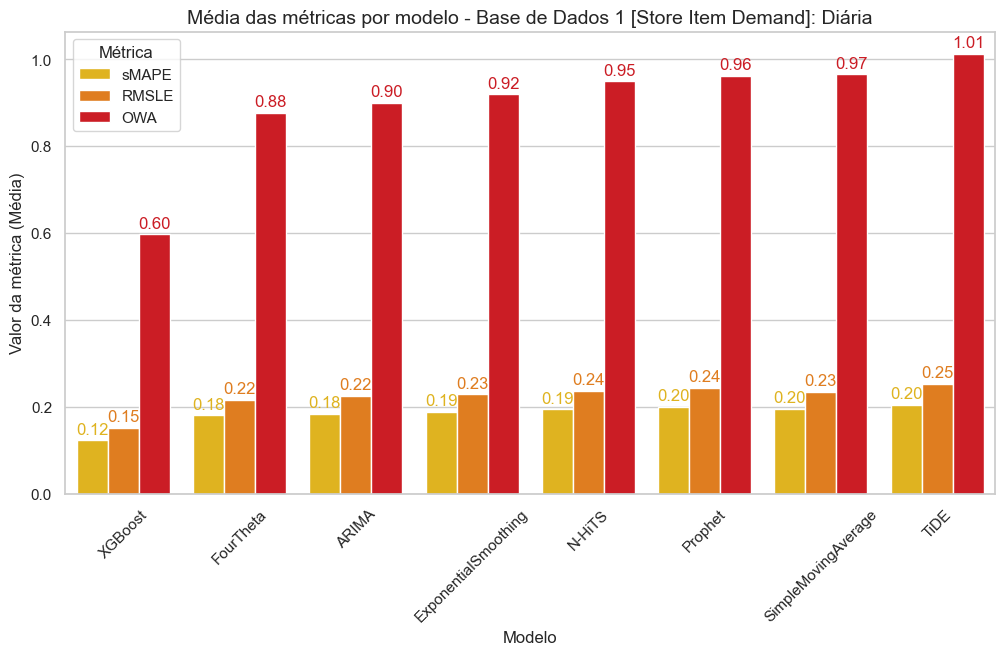

In [24]:
palette = sns.color_palette(
    [
        get_palette_color(palette="bright", color="yellow"), 
        get_palette_color(palette="bright", color="orange"), 
        get_palette_color(palette="bright", color="red"), 
    ]
)

legend_labels = {
    "smape_mean": "sMAPE", 
    "rmsle_mean": "RMSLE", 
    "owa_mean": "OWA"
}

adjusted_barplot(
    data=globals()["daily_metrics_mean"], x="model", y="value", hue="metric_mean", palette=palette,
    xlabel="Modelo", ylabel="Valor da métrica (Média)", legend="Métrica", legend_labels=legend_labels, 
    title_size=14, title="Média das métricas por modelo - Base de Dados 1 [Store Item Demand]: Diária"
)

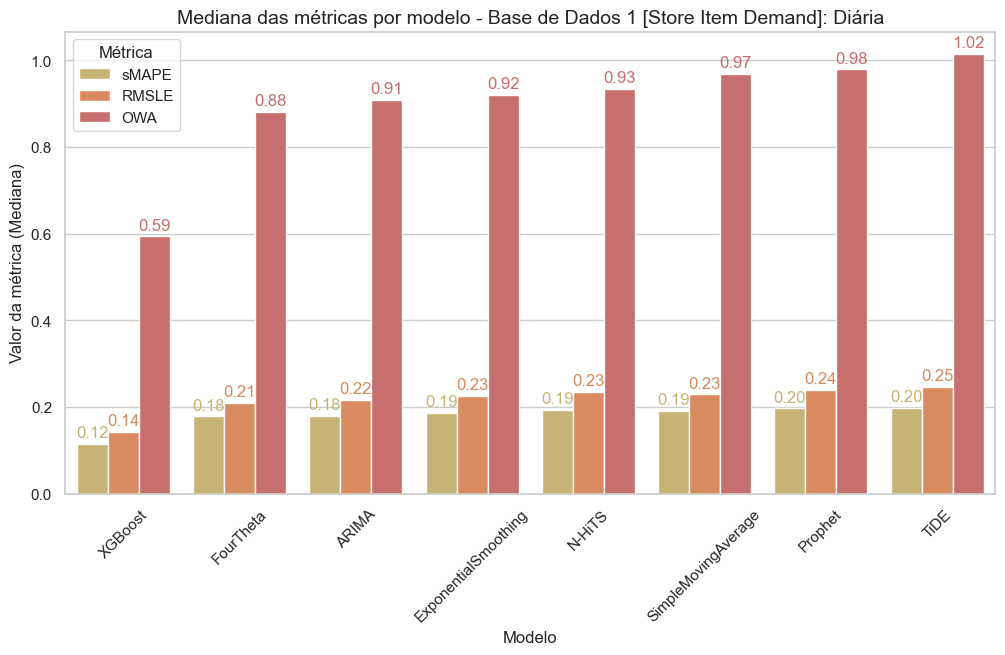

In [25]:
palette = sns.color_palette(
    [
        get_palette_color(palette="muted", color="yellow"), 
        get_palette_color(palette="muted", color="orange"), 
        get_palette_color(palette="muted", color="red"), 
    ]
)

legend_labels = {
    "smape_median": "sMAPE", 
    "rmsle_median": "RMSLE", 
    "owa_median": "OWA"
}

adjusted_barplot(
    data=globals()["daily_metrics_median"], x="model", y="value", hue="metric_median", palette=palette,
    xlabel="Modelo", ylabel="Valor da métrica (Mediana)", legend="Métrica", legend_labels=legend_labels, 
    title_size=14, title="Mediana das métricas por modelo - Base de Dados 1 [Store Item Demand]: Diária"
)

- Além de ser o modelo mais lento, o *TiDE* também apresentou as piores médias e medianas em todas as métricas;

- Por outro lado, o *XGBoost* foi o modelo que alcançou as melhores médias e medianas em todas as métricas;

- Durante a comparação das médias, o *Prophet* superou a *S.M.A.* na OWA; no entanto, esse cenário se inverteu durante a comparação das medianas. Considerando que a Média Móvel Simples apresenta métricas sMAPE e RMLSE superiores em ambos os casos, essa diferença na OWA pode ter ocorrido devido à presença de algum outlier.

#### **Frequência Semanal**

In [26]:
globals()["weekly_analysis"].describe()

statistic,model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""8""",8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,28.4384,0.0967125,0.10935,1.0714375,27.976112,0.090225,0.101675,1.0116
"""std""",null,24.835295,0.041357,0.045679,0.508645,24.555265,0.035563,0.038137,0.403978
"""min""","""ARIMA""",0.2245,0.0557,0.0652,0.6821,0.1954,0.0525,0.0623,0.6618
"""25%""",null,8.6754,0.0646,0.0748,0.7674,8.0827,0.0587,0.0679,0.724
"""50%""",null,40.8852,0.0947,0.1064,0.9414,39.4349,0.0912,0.1032,0.9424
"""75%""",null,41.9614,0.1052,0.1202,1.0886,42.2498,0.1038,0.1187,1.0639
"""max""","""XGBoost""",69.0133,0.183,0.207,2.2514,68.0801,0.1558,0.1736,1.909


In [27]:
globals()["weekly_analysis"].sort(f"{key_metric}_mean")

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""XGBoost""",47.8347,0.0557,0.0652,0.6821,47.1288,0.0538,0.0623,0.6618
"""FourTheta""",4.4577,0.06,0.0703,0.7247,4.4808,0.0525,0.0625,0.7077
"""ExponentialSmo…",8.6754,0.0646,0.0748,0.7674,8.0827,0.0587,0.0679,0.724
"""ARIMA""",14.455,0.0947,0.1054,0.9221,14.1564,0.0912,0.1014,0.919
"""Prophet""",40.8852,0.0942,0.1064,0.9414,39.4349,0.0908,0.1032,0.9424
"""SimpleMovingAv…",0.2245,0.1163,0.1255,1.0886,0.1954,0.1152,0.1238,1.0639
"""TiDE""",69.0133,0.1052,0.1202,1.1938,68.0801,0.1038,0.1187,1.165
"""N-HiTS""",41.9614,0.183,0.207,2.2514,42.2498,0.1558,0.1736,1.909


In [28]:
globals()["weekly_analysis"].sort(f"{key_metric}_median")

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""XGBoost""",47.8347,0.0557,0.0652,0.6821,47.1288,0.0538,0.0623,0.6618
"""FourTheta""",4.4577,0.06,0.0703,0.7247,4.4808,0.0525,0.0625,0.7077
"""ExponentialSmo…",8.6754,0.0646,0.0748,0.7674,8.0827,0.0587,0.0679,0.724
"""ARIMA""",14.455,0.0947,0.1054,0.9221,14.1564,0.0912,0.1014,0.919
"""Prophet""",40.8852,0.0942,0.1064,0.9414,39.4349,0.0908,0.1032,0.9424
"""SimpleMovingAv…",0.2245,0.1163,0.1255,1.0886,0.1954,0.1152,0.1238,1.0639
"""TiDE""",69.0133,0.1052,0.1202,1.1938,68.0801,0.1038,0.1187,1.165
"""N-HiTS""",41.9614,0.183,0.207,2.2514,42.2498,0.1558,0.1736,1.909


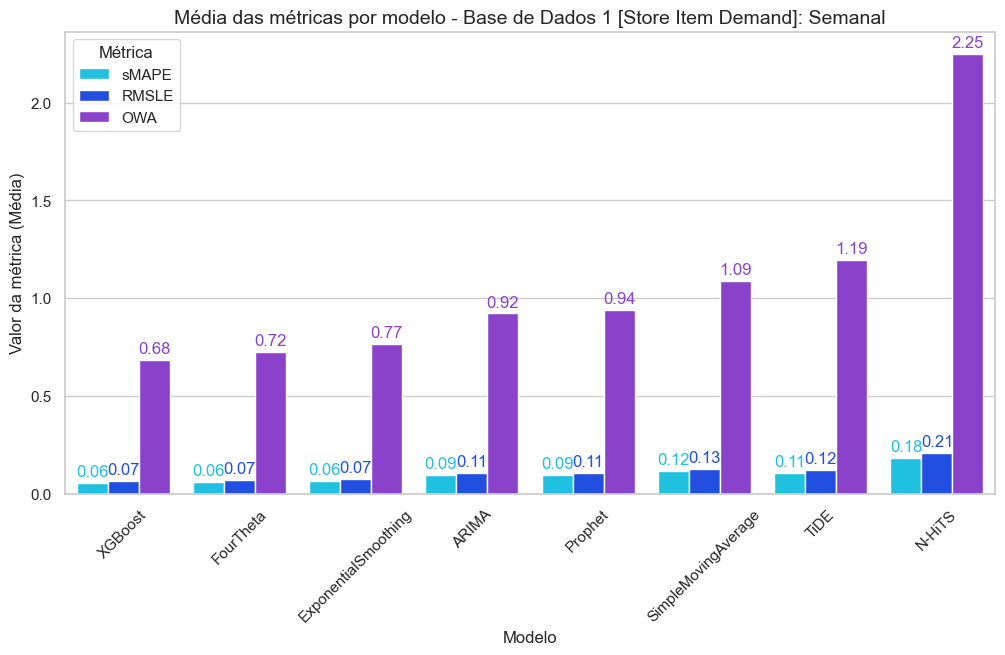

In [29]:
palette = sns.color_palette(
    [
        get_palette_color(palette="bright", color="light blue"), 
        get_palette_color(palette="bright", color="blue"), 
        get_palette_color(palette="bright", color="purple"), 
    ]
)

legend_labels = {
    "smape_mean": "sMAPE", 
    "rmsle_mean": "RMSLE", 
    "owa_mean": "OWA"
}

adjusted_barplot(
    data=globals()["weekly_metrics_mean"], x="model", y="value", hue="metric_mean", palette=palette,
    xlabel="Modelo", ylabel="Valor da métrica (Média)", legend="Métrica", legend_labels=legend_labels, 
    title_size=14, title="Média das métricas por modelo - Base de Dados 1 [Store Item Demand]: Semanal"
)

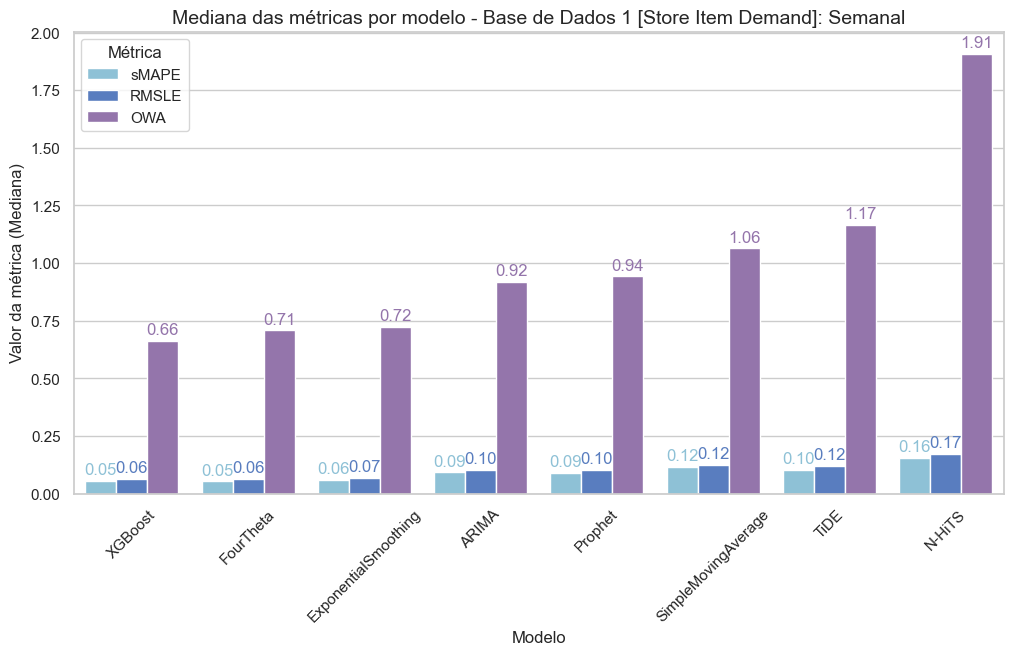

In [30]:
palette = sns.color_palette(
    [
        get_palette_color(palette="muted", color="light blue"), 
        get_palette_color(palette="muted", color="blue"), 
        get_palette_color(palette="muted", color="purple"), 
    ]
)

legend_labels = {
    "smape_median": "sMAPE", 
    "rmsle_median": "RMSLE", 
    "owa_median": "OWA"
}

adjusted_barplot(
    data=globals()["weekly_metrics_median"], x="model", y="value", hue="metric_median", palette=palette,
    xlabel="Modelo", ylabel="Valor da métrica (Mediana)", legend="Métrica", legend_labels=legend_labels, 
    title_size=14, title="Mediana das métricas por modelo - Base de Dados 1 [Store Item Demand]: Semanal"
)

- Aparentemente, o *N-HiTS* foi o único modelo que apresentou outliers prejudiciais nos resultados. Na frequência diária, seus valores de sMAPE, RMSLE e OWA foram 0,18, 0,21 e 2,25, respectivamente, enquanto na frequência semanal foram 0,16, 0,17 e 1,91;

- Com as demandas agregadas em frequência semanal, o *N-HiTS* apresentou as piores médias e medianas em todas as métricas;

- Por outro lado, o *XGBoost* foi o modelo que alcançou as melhores médias e medianas em todas as métricas;

- A ordenação dos modelos se manteve tanto nas médias quanto nas medianas, o que indica uma consistência nos resultados e confirma a performance superior do *XGBoost* e a inferior do *N-HiTS* diante dessas demandas agregadas em frequência semanal.

### **Frequência Diária x Semanal**

#### **Tempo de execução**

In [31]:
globals()["ordered_execution_time"]

model,execution_time,value
str,str,f64
"""SimpleMovingAv…","""daily_executio…",0.2799
"""FourTheta""","""daily_executio…",6.6134
"""ARIMA""","""daily_executio…",36.3228
"""ExponentialSmo…","""daily_executio…",37.2966
"""XGBoost""","""daily_executio…",77.7734
…,…,…
"""ExponentialSmo…","""weekly_executi…",8.6754
"""XGBoost""","""weekly_executi…",47.8347
"""Prophet""","""weekly_executi…",40.8852


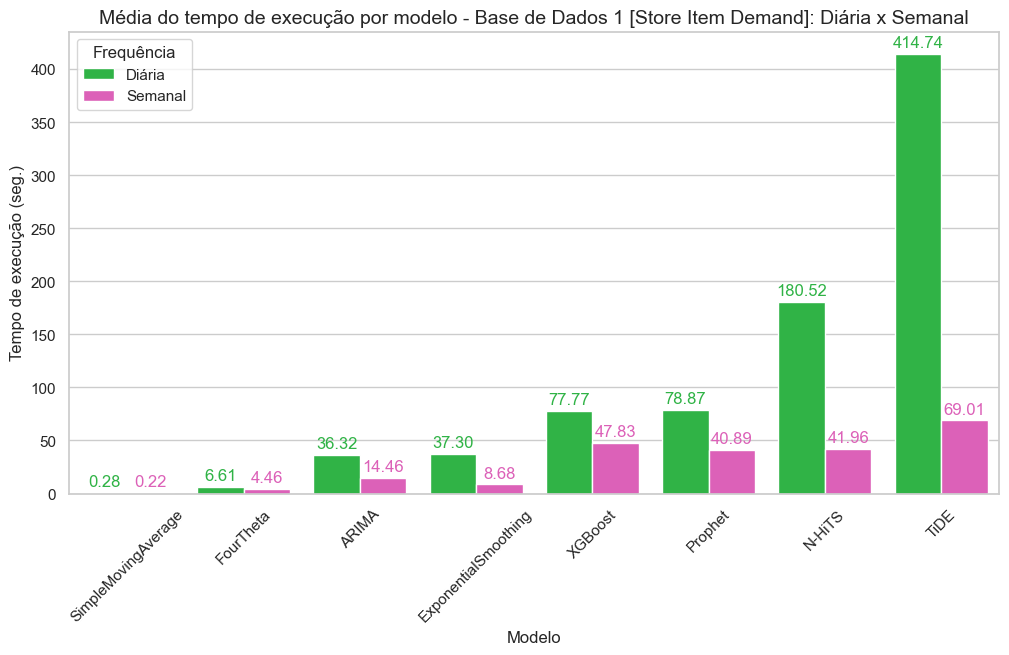

In [32]:
palette = sns.color_palette(
    [   
        get_palette_color(palette="bright", color="green"),
        get_palette_color(palette="bright", color="pink"),
    ]
)

legend_labels = {
    "daily_execution_time_mean": "Diária", 
    "weekly_execution_time_mean": "Semanal"
}

adjusted_barplot(
    data=globals()["ordered_execution_time"], x="model", y="value", hue="execution_time", palette=palette,
    xlabel="Modelo", ylabel="Tempo de execução (seg.)", legend="Frequência", legend_labels=legend_labels, 
    title_size=14, title="Média do tempo de execução por modelo - Base de Dados 1 [Store Item Demand]: Diária x Semanal"
)

In [33]:
globals()["execution_time_comparison"].sort("reduction_percent")

model,daily_execution_time_mean,weekly_execution_time_mean,reduction_percent
str,f64,f64,f64
"""TiDE""",414.7429,69.0133,-0.8336
"""N-HiTS""",180.5167,41.9614,-0.7675
"""ExponentialSmo…",37.2966,8.6754,-0.7674
"""ARIMA""",36.3228,14.455,-0.602
"""Prophet""",78.8674,40.8852,-0.4816
"""XGBoost""",77.7734,47.8347,-0.3849
"""FourTheta""",6.6134,4.4577,-0.326
"""SimpleMovingAv…",0.2799,0.2245,-0.1979


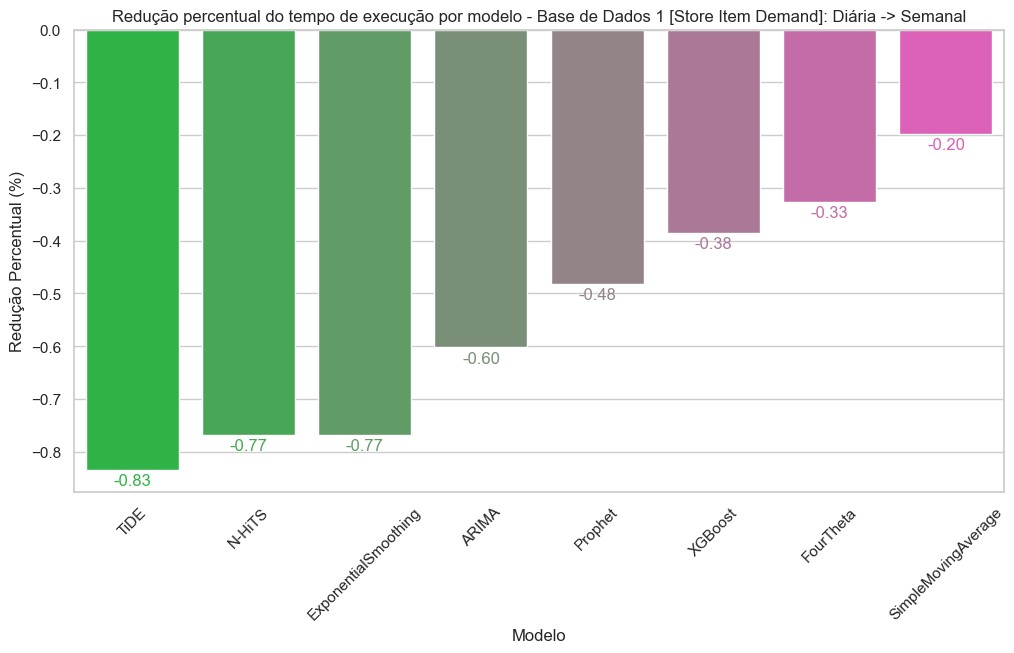

In [34]:
palette = sns.blend_palette(
    [
        get_palette_color(palette="bright", color="green"),
        get_palette_color(palette="bright", color="pink")
    ], 
    n_colors=len(globals()["execution_time_comparison"])
)

adjusted_barplot(
    data=globals()["execution_time_comparison"].sort("reduction_percent"), x="model", y="reduction_percent", 
    hue="model", xlabel="Modelo", ylabel="Redução Percentual (%)", legend=False, palette=palette, title_size=12,
    title="Redução percentual do tempo de execução por modelo - Base de Dados 1 [Store Item Demand]: Diária -> Semanal"
)

- De acordo com os gráficos, é possível observar que os dois modelos mais rápidos, *S.M.A.* e *FourTheta*, apresentaram as menores reduções no tempo de execução ao passar da base com frequência diária para semanal, com reduções de 19,80% e 32,60%, respectivamente. Por outro lado, os dois modelos mais lentos, *TiDE* e *N-HiTS*, sofreram as maiores reduções, com diminuições de 83,36% e 76,75%, respectivamente. Os demais modelos não seguiram um padrão específico, mas todos apresentaram reduções significativas.

#### **sMAPE**

In [35]:
globals()["ordered_smape"]

model,smape,value
str,str,f64
"""XGBoost""","""daily_smape_me…",0.1221
"""FourTheta""","""daily_smape_me…",0.18
"""ARIMA""","""daily_smape_me…",0.1839
"""ExponentialSmo…","""daily_smape_me…",0.1881
"""N-HiTS""","""daily_smape_me…",0.1935
…,…,…
"""ExponentialSmo…","""weekly_smape_m…",0.0646
"""N-HiTS""","""weekly_smape_m…",0.183
"""SimpleMovingAv…","""weekly_smape_m…",0.1163


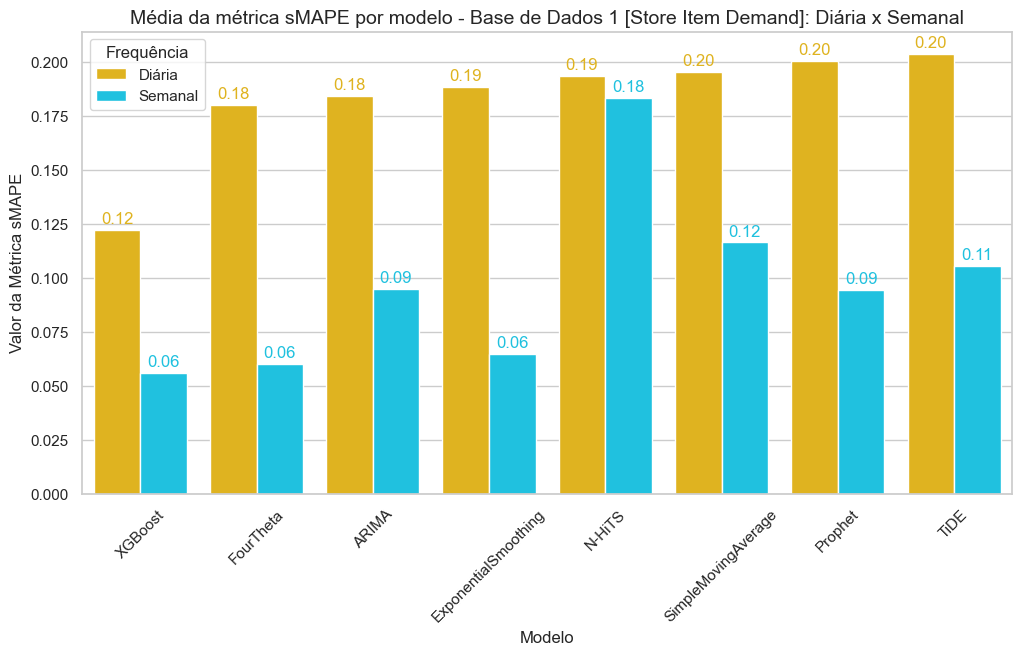

In [36]:
palette = sns.color_palette(
    [   
        get_palette_color(palette="bright", color="yellow"),
        get_palette_color(palette="bright", color="light blue"),
    ]
)

legend_labels = {
    "daily_smape_mean": "Diária", 
    "weekly_smape_mean": "Semanal"
}

adjusted_barplot(
    data=globals()["ordered_smape"], x="model", y="value", hue="smape", palette=palette, xlabel="Modelo", 
    ylabel="Valor da Métrica sMAPE", legend="Frequência", legend_labels=legend_labels, title_size=14,
    title="Média da métrica sMAPE por modelo - Base de Dados 1 [Store Item Demand]: Diária x Semanal"
)

In [37]:
globals()[f"smape_comparison"].sort("reduction_percent")

model,daily_smape_mean,weekly_smape_mean,reduction_percent
str,f64,f64,f64
"""FourTheta""",0.18,0.06,-0.6667
"""ExponentialSmo…",0.1881,0.0646,-0.6566
"""XGBoost""",0.1221,0.0557,-0.5438
"""Prophet""",0.2002,0.0942,-0.5295
"""ARIMA""",0.1839,0.0947,-0.485
"""TiDE""",0.2037,0.1052,-0.4836
"""SimpleMovingAv…",0.1951,0.1163,-0.4039
"""N-HiTS""",0.1935,0.183,-0.0543


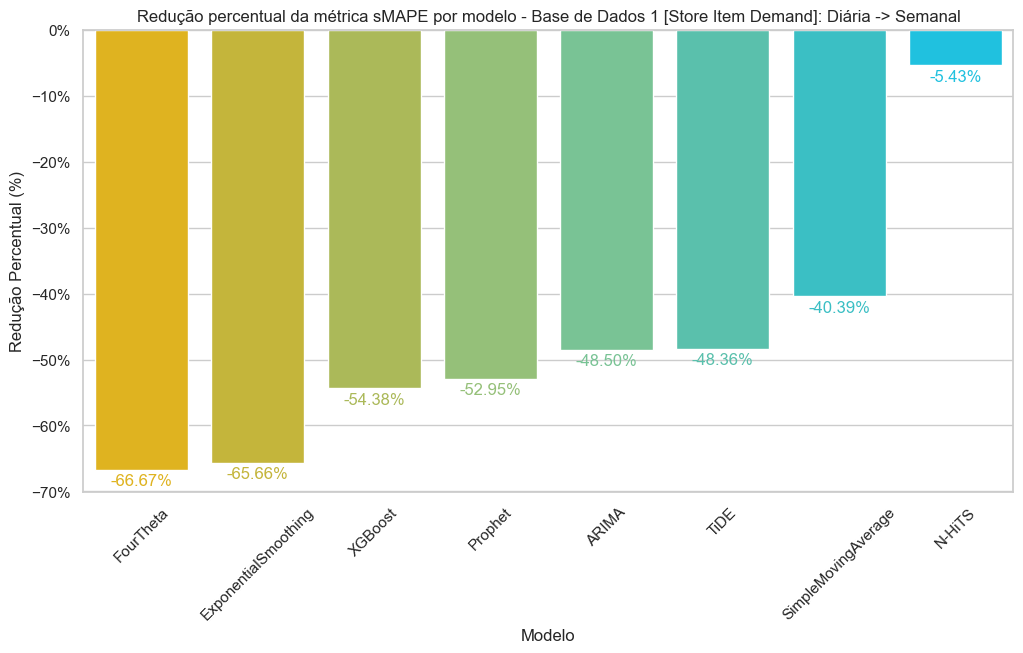

In [38]:
palette = sns.blend_palette(
    [
        get_palette_color(palette="bright", color="yellow"),
        get_palette_color(palette="bright", color="light blue")
    ], n_colors=len(globals()["smape_comparison"])
)

adjusted_barplot(
    data=globals()["smape_comparison"].sort("reduction_percent"), x="model", y="reduction_percent", y_is_percent=True,
    hue="model", xlabel="Modelo", ylabel="Redução Percentual (%)", legend=False, palette=palette, title_size=12,
    title="Redução percentual da métrica sMAPE por modelo - Base de Dados 1 [Store Item Demand]: Diária -> Semanal", 
)

- Ao analisar os gráficos após a agregação em frequência semanal, é notável a melhora na métrica sMAPE dos modelos;

- O modelo *N-HiTS* teve a menor redução percentual, ou seja, foi o menos beneficiado pela agregação, com -5,46%. Enquanto isso, o modelo *FourTheta* obteve a maior redução, sendo o mais beneficiado pela agregação, com -66,65%.

#### **RMSLE**

In [39]:
globals()["ordered_rmsle"]

model,rmsle,value
str,str,f64
"""XGBoost""","""daily_rmsle_me…",0.1506
"""FourTheta""","""daily_rmsle_me…",0.2157
"""ARIMA""","""daily_rmsle_me…",0.2243
"""ExponentialSmo…","""daily_rmsle_me…",0.2285
"""SimpleMovingAv…","""daily_rmsle_me…",0.2346
…,…,…
"""ExponentialSmo…","""weekly_rmsle_m…",0.0748
"""SimpleMovingAv…","""weekly_rmsle_m…",0.1255
"""N-HiTS""","""weekly_rmsle_m…",0.207


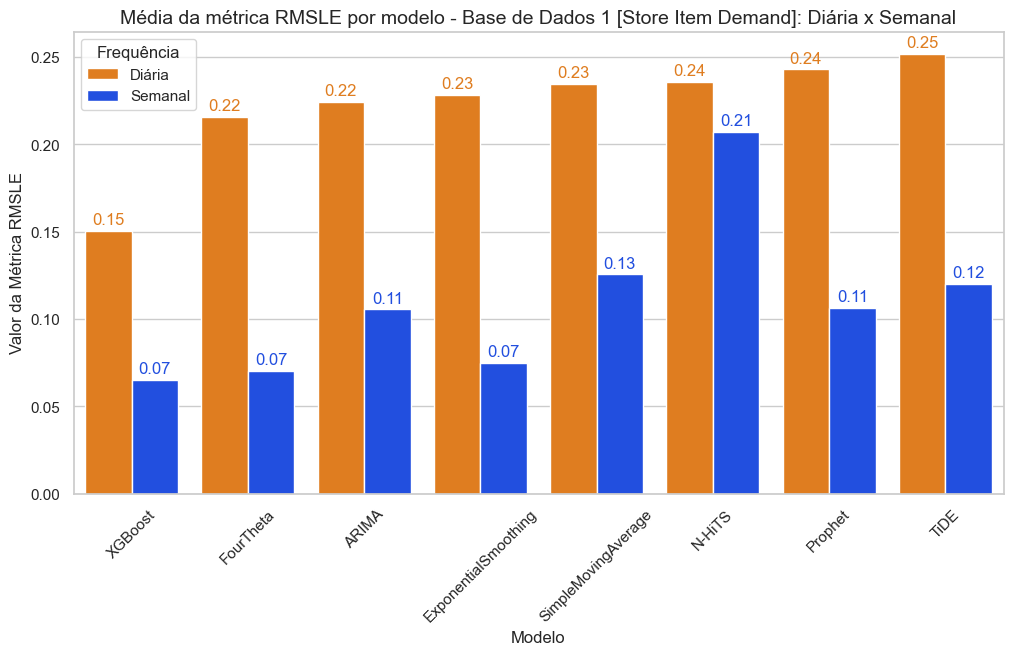

In [40]:
palette = sns.color_palette(
    [   
        get_palette_color(palette="bright", color="orange"),
        get_palette_color(palette="bright", color="blue"),
    ]
)

legend_labels = {
    "daily_rmsle_mean": "Diária", 
    "weekly_rmsle_mean": "Semanal"
}

adjusted_barplot(
    data=globals()["ordered_rmsle"], x="model", y="value", hue="rmsle", palette=palette, xlabel="Modelo", 
    ylabel="Valor da Métrica RMSLE", legend="Frequência", legend_labels=legend_labels, title_size=14,
    title="Média da métrica RMSLE por modelo - Base de Dados 1 [Store Item Demand]: Diária x Semanal"
)

In [41]:
globals()[f"rmsle_comparison"].sort("reduction_percent")

model,daily_rmsle_mean,weekly_rmsle_mean,reduction_percent
str,f64,f64,f64
"""FourTheta""",0.2157,0.0703,-0.6741
"""ExponentialSmo…",0.2285,0.0748,-0.6726
"""XGBoost""",0.1506,0.0652,-0.5671
"""Prophet""",0.2429,0.1064,-0.562
"""ARIMA""",0.2243,0.1054,-0.5301
"""TiDE""",0.252,0.1202,-0.523
"""SimpleMovingAv…",0.2346,0.1255,-0.465
"""N-HiTS""",0.2358,0.207,-0.1221


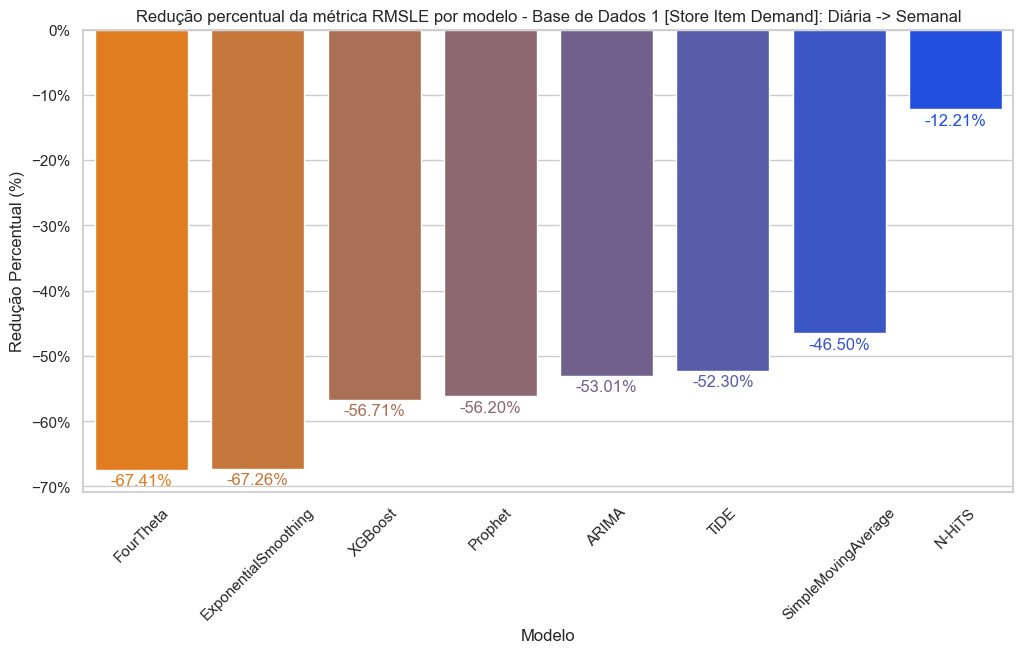

In [42]:
palette = sns.blend_palette(
    [
        get_palette_color(palette="bright", color="orange"),
        get_palette_color(palette="bright", color="blue")
    ], n_colors=len(globals()["rmsle_comparison"])
)

adjusted_barplot(
    data=globals()["rmsle_comparison"].sort("reduction_percent"), x="model", y="reduction_percent", y_is_percent=True,
    hue="model", xlabel="Modelo", ylabel="Redução Percentual (%)", legend=False, palette=palette, title_size=12,
    title="Redução percentual da métrica RMSLE por modelo - Base de Dados 1 [Store Item Demand]: Diária -> Semanal", 
)

- Mais uma vez, ao analisar os gráficos após a agregação em frequência semanal, é notável a melhora na métrica RMSLE dos modelos;

- O modelo *N-HiTS* novamente teve a menor redução percentual, ou seja, foi o menos beneficiado pela agregação, com -12,20%. Enquanto isso, o modelo *FourTheta* outra vez obteve a maior redução, sendo o mais beneficiado pela agregação, com -67,40%.

#### **OWA**

In [43]:
globals()["ordered_owa"]

model,owa,value
str,str,f64
"""XGBoost""","""daily_owa_mean…",0.5969
"""FourTheta""","""daily_owa_mean…",0.8758
"""ARIMA""","""daily_owa_mean…",0.8997
"""ExponentialSmo…","""daily_owa_mean…",0.9193
"""N-HiTS""","""daily_owa_mean…",0.9491
…,…,…
"""ExponentialSmo…","""weekly_owa_mea…",0.7674
"""N-HiTS""","""weekly_owa_mea…",2.2514
"""Prophet""","""weekly_owa_mea…",0.9414


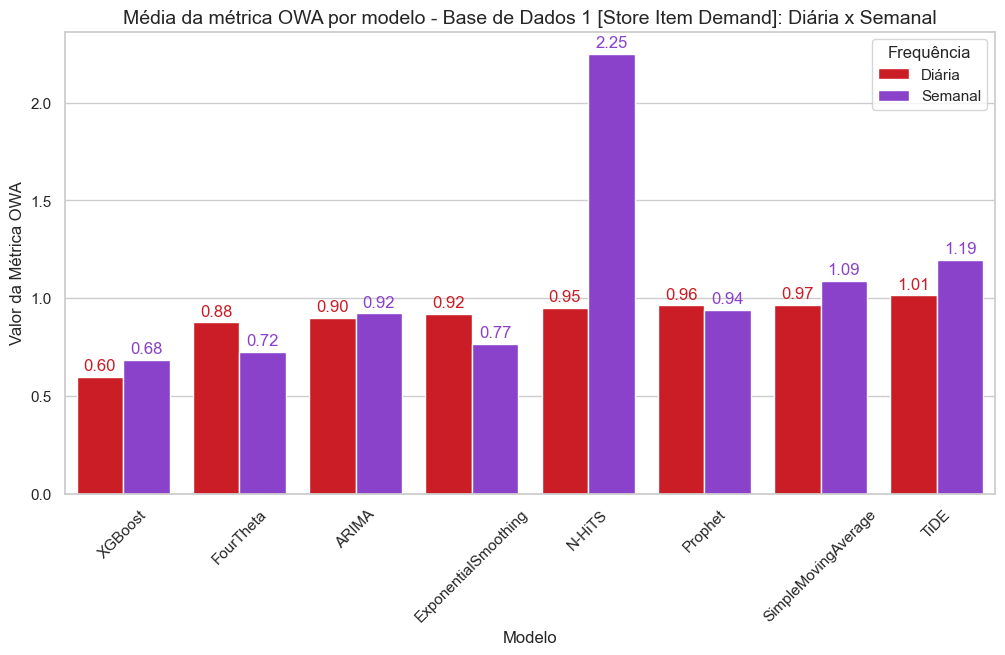

In [44]:
palette = sns.color_palette(
    [   
        get_palette_color(palette="bright", color="red"),
        get_palette_color(palette="bright", color="purple"),
    ]
)

legend_labels = {
    "daily_owa_mean": "Diária", 
    "weekly_owa_mean": "Semanal"
}

adjusted_barplot(
    data=globals()["ordered_owa"], x="model", y="value", hue="owa", palette=palette, xlabel="Modelo", 
    ylabel="Valor da Métrica OWA", legend="Frequência", legend_labels=legend_labels, title_size=14,
    title="Média da métrica OWA por modelo - Base de Dados 1 [Store Item Demand]: Diária x Semanal"
)

In [45]:
globals()[f"owa_comparison"].sort("reduction_percent")

model,daily_owa_mean,weekly_owa_mean,reduction_percent
str,f64,f64,f64
"""FourTheta""",0.8758,0.7247,-0.1725
"""ExponentialSmo…",0.9193,0.7674,-0.1652
"""Prophet""",0.9622,0.9414,-0.0216
"""ARIMA""",0.8997,0.9221,0.0249
"""SimpleMovingAv…",0.9654,1.0886,0.1276
"""XGBoost""",0.5969,0.6821,0.1427
"""TiDE""",1.0133,1.1938,0.1781
"""N-HiTS""",0.9491,2.2514,1.3721


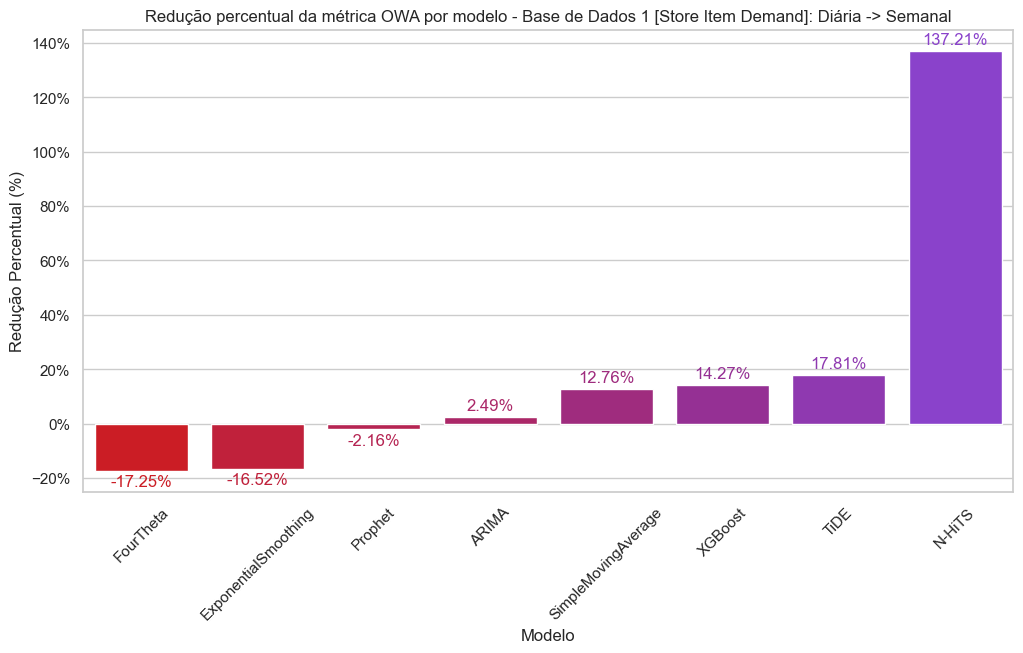

In [46]:
palette = sns.blend_palette(
    [
        get_palette_color(palette="bright", color="red"),
        get_palette_color(palette="bright", color="purple")
    ], n_colors=len(globals()["owa_comparison"])
)

adjusted_barplot(
    data=globals()["owa_comparison"].sort("reduction_percent"), x="model", y="reduction_percent", y_is_percent=True, 
    hue="model", xlabel="Modelo", ylabel="Redução Percentual (%)", legend=False, palette=palette, title_size=12,
    title="Redução percentual da métrica OWA por modelo - Base de Dados 1 [Store Item Demand]: Diária -> Semanal", 
)

-  Dessa vez, ao analisar os gráficos após a agregação em frequência semanal, é possível observar que a métrica OWA melhorou apenas em 3 modelos e piorou em 5. Essa piora pode ser atribuída ao desempenho superior da métrica sMAPE e RMSLE no modelo *Naive*, que teve uma melohra considerável em ambas as métricas, afetando a OWA na maioria dos modelos;

- O modelo *N-HiTS* foi o mais afetado pela agregação, com um aumento percentual de 137,20%. Por outro lado, o modelo *FourTheta* obteve novamente a maior redução, com -17,24%. Além disso, o *ExponentialSmoothing* (que também obteve reduções muito próximas do *FourTheta* no sMAPE e RMSLE) e o *Prophet* também se beneficiaram da agregação, com reduções percentuais de -16,52% e -2,16%, respectivamente.

## **Melhor modelo por unique_id**

In [47]:
find_lower_metric = lambda group, key_metric: group[group[key_metric].arg_min()]

### **Frequência Diária**

In [48]:
daily_grouped_uids = daily_results.group_by("unique_id", maintain_order=True)
daily_best_models = (
    daily_grouped_uids
    .map_groups(lambda group: find_lower_metric(group, key_metric))
    .drop_nulls()
    .sort("unique_id")   
)

daily_best_models

unique_id,store,item,transformation,model,execution_time,smape,rmsle,owa
str,str,str,str,str,f64,f64,f64,f64
"""01_04""","""01""","""04""","""original""","""XGBoost""",75.298801,0.174351,0.211889,0.878132
"""01_13""","""01""","""13""","""original""","""XGBoost""",67.121149,0.088015,0.114518,0.431476
"""01_14""","""01""","""14""","""original""","""XGBoost""",78.27494,0.098808,0.121926,0.510318
"""01_16""","""01""","""16""","""original""","""XGBoost""",69.360116,0.206551,0.24317,0.602757
"""01_17""","""01""","""17""","""original""","""XGBoost""",71.295893,0.14329,0.174502,0.599087
…,…,…,…,…,…,…,…,…
"""10_31""","""10""","""31""","""original""","""XGBoost""",86.832596,0.095595,0.117079,0.566346
"""10_34""","""10""","""34""","""original""","""XGBoost""",70.767708,0.126139,0.155454,0.702889
"""10_37""","""10""","""37""","""original""","""XGBoost""",68.593074,0.12857,0.153709,0.607755


In [49]:
daily_best_models["model"].value_counts(sort=True)

model,count
str,u32
"""XGBoost""",100


- Considerando que o XGBoost foi consistentemente o melhor modelo em todos os casos (100; 100%), é razoável presumir que as séries temporais diárias analisadas apresentaram um menor resíduo ao utilizá-lo. Isso sugere que o uso de modelos do tipo *ensemble* para a previsão dessas séries temporais deve ser avaliado, dada a superioridade de desempenho desses modelos nos casos analisados. É importante observar que esses modelos não possuem a capacidade de analisar tendências e/ou sazonalidades das séries temporais, características essenciais para os modelos desenvolvidos para esse propósito.

### **Frequência Semanal**

In [50]:
weekly_grouped_uids = weekly_results.group_by("unique_id", maintain_order=True)
weekly_best_models = (
    weekly_grouped_uids
    .map_groups(lambda group: find_lower_metric(group, key_metric))
    .drop_nulls()
    .sort("unique_id")   
)

weekly_best_models

unique_id,store,item,transformation,model,execution_time,smape,rmsle,owa
str,str,str,str,str,f64,f64,f64,f64
"""01_04""","""01""","""04""","""original""","""XGBoost""",43.31461,0.096992,0.1097,0.779293
"""01_13""","""01""","""13""","""original""","""XGBoost""",59.812314,0.031082,0.034841,0.633794
"""01_14""","""01""","""14""","""original""","""XGBoost""",51.41849,0.041938,0.047217,0.576184
"""01_16""","""01""","""16""","""original""","""XGBoost""",41.351627,0.04502,0.050223,0.456749
"""01_17""","""01""","""17""","""original""","""XGBoost""",50.081788,0.048932,0.060985,0.666459
…,…,…,…,…,…,…,…,…
"""10_31""","""10""","""31""","""original""","""XGBoost""",54.427869,0.045629,0.060305,0.652298
"""10_34""","""10""","""34""","""original""","""XGBoost""",53.04345,0.037869,0.044912,0.343412
"""10_37""","""10""","""37""","""original""","""FourTheta""",4.732616,0.056575,0.06621,0.755873


In [51]:
weekly_best_models_vc = weekly_best_models["model"].value_counts(sort=True)
weekly_best_models_vc

model,count
str,u32
"""XGBoost""",57
"""FourTheta""",30
"""ExponentialSmo…",7
"""Prophet""",3
"""ARIMA""",2
"""TiDE""",1


In [52]:
# Adicionando modelos que não foram selecionados para gerar gráfico de barras
models = weekly_results["model"].unique()
add_models = [
    {"model": model, "count": 0} for model in models if model not in weekly_best_models_vc["model"].unique(maintain_order=True)
]
new_df = pl.DataFrame(add_models, schema={"model": pl.Utf8, "count": pl.UInt32})
weekly_best_models_vc = weekly_best_models_vc.vstack(new_df)
weekly_best_models_vc


model,count
str,u32
"""XGBoost""",57
"""FourTheta""",30
"""ExponentialSmo…",7
"""Prophet""",3
"""ARIMA""",2
"""TiDE""",1
"""SimpleMovingAv…",0
"""N-HiTS""",0


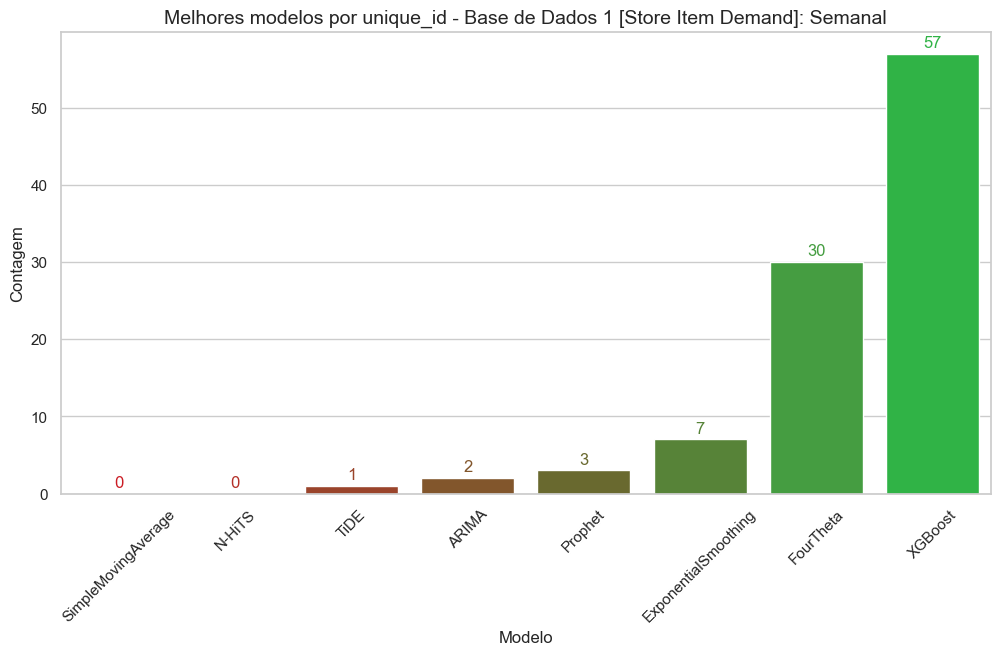

In [53]:
palette = sns.blend_palette(
    [
        get_palette_color(palette="bright", color="red"),
        get_palette_color(palette="bright", color="green")
    ], n_colors=len(weekly_best_models_vc)
)

adjusted_barplot(
    data=weekly_best_models_vc.sort("count"), x="model", y="count", hue="model", xlabel="Modelo", ylabel="Contagem", y_is_count=True,
    legend=False, palette=palette, title_size=14, title="Melhores modelos por unique_id - Base de Dados 1 [Store Item Demand]: Semanal", 
)

- Após a agregação em frequência semanal, o *XGBoost* não foi o melhor modelo em todos os casos, mas continuou sendo o mais selecionado, com 57 casos (57%). O *FourTheta*, modelo que obteve as maiores melhorias nas métricas, foi o melhor em 30 casos (30%), seguido pelo *ExponentialSmoothing*, que também obteve ótimas melhorias, com 7 casos (7%). Os modelos *Prophet*, *ARIMA* e *TiDE* foram melhores em 3 (3%), 2 (2%) e 1 (1%) caso, respectivamente. O *N-HiTS*, que piorou sua OWA, e o *S.M.A*., apesar de ser o mais rápido, não foram selecionados em nenhum caso (0%).

# **Base de dados 2: Food Demand**

- Tempo total de execução (12 núcleos com paralelismo): 
    - **Frequência Semanal:** 544 séries -> 2 horas, 8 minutos e 24.92 segundos

## **Leitura dos Dados**

In [54]:
with open("../conf/base/parameters.yml", "r") as file:
    parameters = yaml.safe_load(file)

In [55]:
food_results = pl.read_parquet("../data/08_reporting/RESULTS_FOOD_WEEKLY.pq")
food_results.describe()

statistic,unique_id,center,meal,transformation,model,execution_time,smape,rmsle,owa
str,str,str,str,str,str,f64,f64,f64,f64
"""count""","""4896""","""4896""","""4896""","""4896""","""4896""",4896.0,4896.0,4896.0,4896.0
"""null_count""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0
"""mean""",null,null,null,null,null,18.661192,0.447128,0.640085,9.3536e6
"""std""",null,null,null,null,null,18.656061,0.219144,0.416941,2.8366e8
"""min""","""010_1109""","""010""","""1062""","""log""","""ARIMA""",0.125,0.065892,0.079244,0.25
"""25%""",null,null,null,null,null,3.780559,0.287499,0.357802,0.711115
"""50%""",null,null,null,null,null,10.690038,0.408285,0.511977,0.822892
"""75%""",null,null,null,null,null,30.492316,0.558774,0.803157,0.948945
"""max""","""186_2760""","""186""","""2867""","""original""","""XGBoost""",102.404851,1.782352,3.335799,1.5321e10


## **Análises**

In [56]:
metrics = parameters.get("METRICS")
key_metric = parameters.get("KEY_METRIC")
analysis_cols = ["execution_time"] + metrics
frequency = "weekly"

### **Valores infinitos (erros)**

In [57]:
food_results.filter(
    pl.fold(
        acc=pl.lit(False),
        function=lambda acc, x: acc | x,
        exprs=[pl.col(col) == np.inf for col in metrics]
    )
)

unique_id,center,meal,transformation,model,execution_time,smape,rmsle,owa
str,str,str,str,str,f64,f64,f64,f64


- Nenhum erro ocorreu durante o treinamento de qualquer modelo/unique_id.

### **Criação das variáveis para análises**

In [58]:
food_analysis = (
    food_results
    .group_by("model")
    .agg(
        *[pl.col(col).mean().round(4).alias(f"{col}_mean") for col in analysis_cols],
        *[pl.col(col).median().round(4).alias(f"{col}_median") for col in analysis_cols]
    )
)

food_analysis.sort("model")

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""ARIMA""",10.8452,0.4339,0.6247,0.7986,10.6559,0.3926,0.4958,0.7918
"""Croston""",2.4565,0.4537,0.6509,0.8294,2.2884,0.4187,0.5261,0.8392
"""ExponentialSmo…",5.2904,0.4453,0.6383,0.8422,5.0695,0.4053,0.506,0.8246
"""FourTheta""",3.9701,0.4427,0.6378,1.1482e7,3.9781,0.4012,0.5071,0.8228
"""N-HiTS""",28.9622,0.4696,0.6616,1.9453e6,28.7092,0.4259,0.5406,0.8704
"""Prophet""",37.7644,0.431,0.6193,0.8082,36.431,0.3924,0.4973,0.799
"""SimpleMovingAv…",0.2076,0.4591,0.6569,1.0105e7,0.1879,0.4216,0.5258,0.8369
"""TiDE""",55.3748,0.437,0.6251,8.0335e6,53.4237,0.3988,0.5008,0.82
"""XGBoost""",23.0795,0.4519,0.6463,5.2617e7,22.4662,0.4155,0.5116,0.8205


### **Tempo de execução**

In [59]:
food_ordered_time = (
    food_analysis
    .sort("execution_time_mean")
    .melt(
        id_vars="model", 
        value_vars=["execution_time_mean", "execution_time_median"], 
        variable_name="execution_time", 
        value_name="value"
    )
)

food_ordered_time

model,execution_time,value
str,str,f64
"""SimpleMovingAv…","""execution_time…",0.2076
"""Croston""","""execution_time…",2.4565
"""FourTheta""","""execution_time…",3.9701
"""ExponentialSmo…","""execution_time…",5.2904
"""ARIMA""","""execution_time…",10.8452
…,…,…
"""ARIMA""","""execution_time…",10.6559
"""XGBoost""","""execution_time…",22.4662
"""N-HiTS""","""execution_time…",28.7092


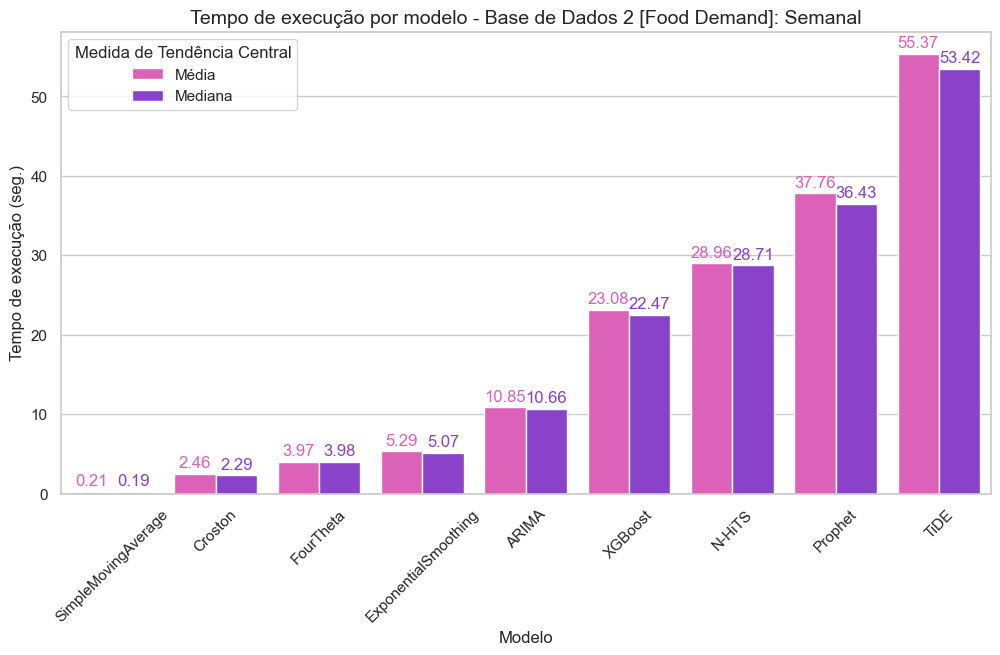

In [60]:
palette = sns.color_palette(
    [
        get_palette_color(palette="bright", color="pink"),
        get_palette_color(palette="bright", color="purple")
    ]
)

legend_labels = {
    "execution_time_mean": "Média", 
    "execution_time_median": "Mediana"
}

adjusted_barplot(
    data=food_ordered_time, x="model", y="value", hue="execution_time", palette=palette,
    xlabel="Modelo", ylabel="Tempo de execução (seg.)", legend="Medida de Tendência Central", title_size=14,
    legend_labels=legend_labels, title="Tempo de execução por modelo - Base de Dados 2 [Food Demand]: Semanal"
)

- Os resultados das médias e medianas foram bastante semelhantes, indicando a ausência de muitos outliers no tempo de execução;

- O *TiDE* se destacou como o modelo mais lento, com um tempo de execução médio de 55,37 segundos, enquanto o *Simple Moving Average* (*S.M.A.*) foi o mais rápido, com um tempo de execução médio de 0,21 segundos.

### **Métricas**

#### **Interpretação da OWA (Métrica Principal)**

- OWA < 1: O modelo está performando melhor do que o modelo *Naive*. Isso significa que as previsões são mais precisas em termos das métricas sMAPE e RMSLE em comparação com as previsões do modelo *Naive*.

- OWA = 1: O modelo tem a mesma performance que o modelo *Naive*. Isso indica que as previsões não são melhores nem piores que as do modelo *Naive*.

- OWA > 1: O modelo está performando pior do que o modelo *Naive*. Isso significa que as previsões são menos precisas em termos das métricas sMAPE e RMSLE em comparação com as previsões do modelo *Naive*.

**Exemplos:**

- Se a OWA for 0.8, isso indica que, em média, o modelo é 20% melhor do que o modelo *Naive*.

- Se a OWA for 1.2, isso indica que, em média, o modelo é 20% pior do que o modelo *Naive*.

In [61]:
food_metrics_mean = (
    food_analysis
    .sort(f"{key_metric}_mean")
    .melt(
        id_vars="model", 
        value_vars=[f"{metric}_mean" for metric in metrics], 
        variable_name=f"metric_mean", 
        value_name="value"
    )
)

food_metrics_median = (
    food_analysis
    .sort(f"{key_metric}_median")
    .melt(
        id_vars="model", 
        value_vars=[f"{metric}_median" for metric in metrics], 
        variable_name=f"metric_median", 
        value_name="value"
    )
)

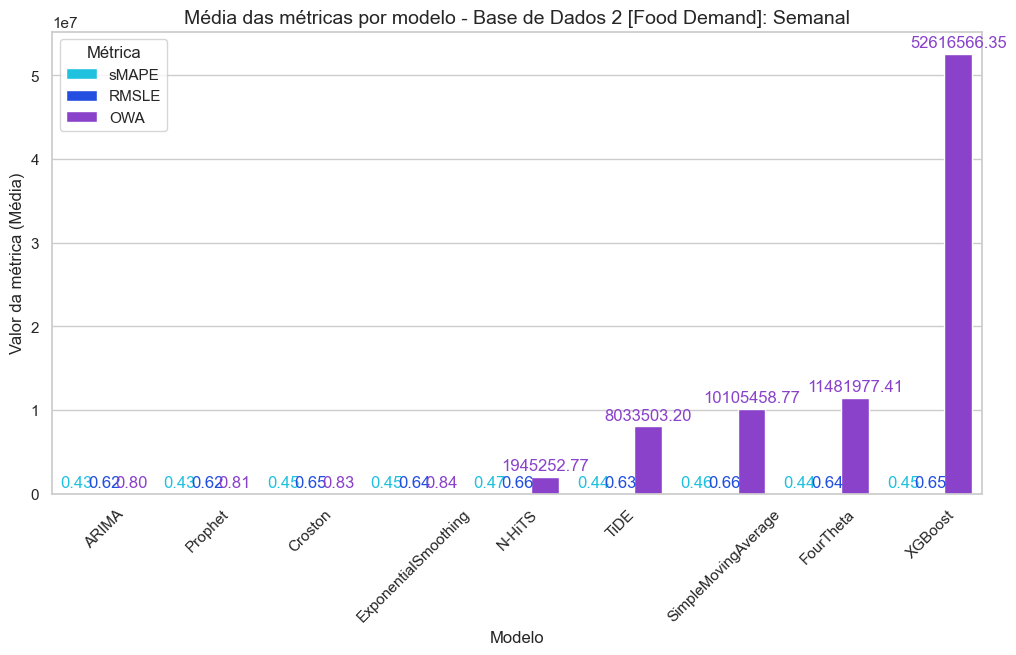

In [62]:
palette = sns.color_palette(
    [
        get_palette_color(palette="bright", color="light blue"), 
        get_palette_color(palette="bright", color="blue"), 
        get_palette_color(palette="bright", color="purple"), 
    ]
)

legend_labels = {
    "smape_mean": "sMAPE", 
    "rmsle_mean": "RMSLE", 
    "owa_mean": "OWA"
}

adjusted_barplot(
    data=food_metrics_mean, x="model", y="value", hue="metric_mean", palette=palette,
    xlabel="Modelo", ylabel="Valor da métrica (Média)", legend="Métrica", legend_labels=legend_labels, 
    title_size=14, title="Média das métricas por modelo - Base de Dados 2 [Food Demand]: Semanal"
)

- Ao observar o gráfico das médias, é possível perceber a existência de outliers na métrica OWA nos modelos. Esses outliers ocorreram porque o modelo *Naive* acertou todas as predições em um ou mais folds da validação cruzada. Para evitar que o sMAPE e o RMSLE resultassem em 0 e gerassem uma OWA infinita, foram ajustados para 1e-10, o que, por sua vez, produziu OWAs extremamente altas.

- Esses outliers extremos não foram excluídos, pois isso "ajudaria" o modelo que está sendo avaliado. Como o *Naive* acertou 100% e o modelo avaliado não, excluir os outliers beneficiaria injustamente o modelo em avaliação.

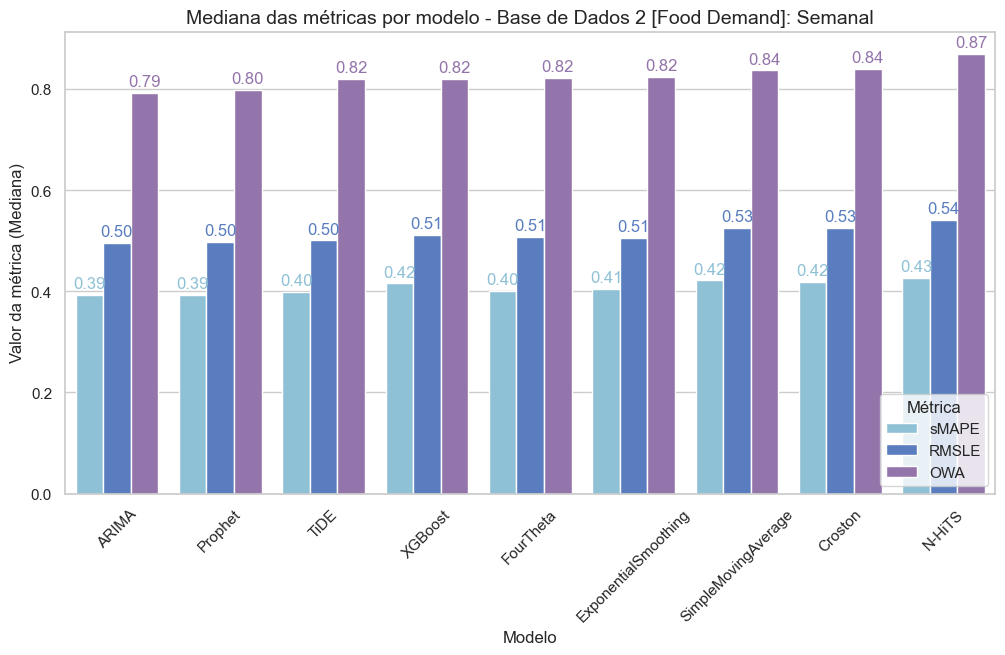

In [63]:
palette = sns.color_palette(
    [
        get_palette_color(palette="muted", color="light blue"), 
        get_palette_color(palette="muted", color="blue"), 
        get_palette_color(palette="muted", color="purple"), 
    ]
)

legend_labels = {
    "smape_median": "sMAPE", 
    "rmsle_median": "RMSLE", 
    "owa_median": "OWA"
}

adjusted_barplot(
    data=food_metrics_median, x="model", y="value", hue="metric_median", palette=palette, xlabel="Modelo", 
    ylabel="Valor da métrica (Mediana)", legend="Métrica", legend_labels=legend_labels, legend_loc="lower right",
    title_size=14, title="Mediana das métricas por modelo - Base de Dados 2 [Food Demand]: Semanal"
)

- Ao observar o gráfico das medianas, é possível perceber um equilíbrio entre os modelos para todas as métricas;

- O *N-HiTS* apresentou as piores medianas em todas as métricas. Por outro lado, o *ARIMA* alcançou a melhor mediana na OWA e, juntamente com o *Prophet* e o *TiDE*, obteve as melhores medianas no sMAPE e no RMSLE.

## **Melhor modelo por unique_id**

In [64]:
find_lower_metric = lambda group, key_metric: group[group[key_metric].arg_min()]

In [65]:
food_grouped_uids = food_results.group_by("unique_id", maintain_order=True)
food_best_models = (
    food_grouped_uids
    .map_groups(lambda group: find_lower_metric(group, key_metric))
    .drop_nulls()
    .sort("unique_id")   
)

food_best_models

unique_id,center,meal,transformation,model,execution_time,smape,rmsle,owa
str,str,str,str,str,f64,f64,f64,f64
"""010_1109""","""010""","""1109""","""original""","""SimpleMovingAv…",0.20314,0.176408,0.233631,0.731802
"""010_1198""","""010""","""1198""","""original""","""TiDE""",45.745133,0.223758,0.283057,0.730011
"""010_1247""","""010""","""1247""","""original""","""N-HiTS""",28.468697,0.494628,0.720932,0.680381
"""010_1311""","""010""","""1311""","""original""","""ARIMA""",10.189281,0.167978,0.217935,0.89543
"""010_1558""","""010""","""1558""","""original""","""XGBoost""",32.248448,0.424322,0.505718,0.51843
…,…,…,…,…,…,…,…,…
"""186_1445""","""186""","""1445""","""original""","""TiDE""",40.126278,0.742069,1.664008,0.859903
"""186_1727""","""186""","""1727""","""original""","""TiDE""",60.048589,0.498081,0.578151,0.780092
"""186_2290""","""186""","""2290""","""original""","""FourTheta""",4.16813,0.45709,0.636025,0.924931


In [66]:
food_best_models_vc = food_best_models["model"].value_counts(sort=True)
food_best_models_vc

model,count
str,u32
"""TiDE""",111
"""XGBoost""",80
"""ARIMA""",75
"""Prophet""",74
"""N-HiTS""",54
"""FourTheta""",54
"""ExponentialSmo…",46
"""Croston""",32
"""SimpleMovingAv…",18


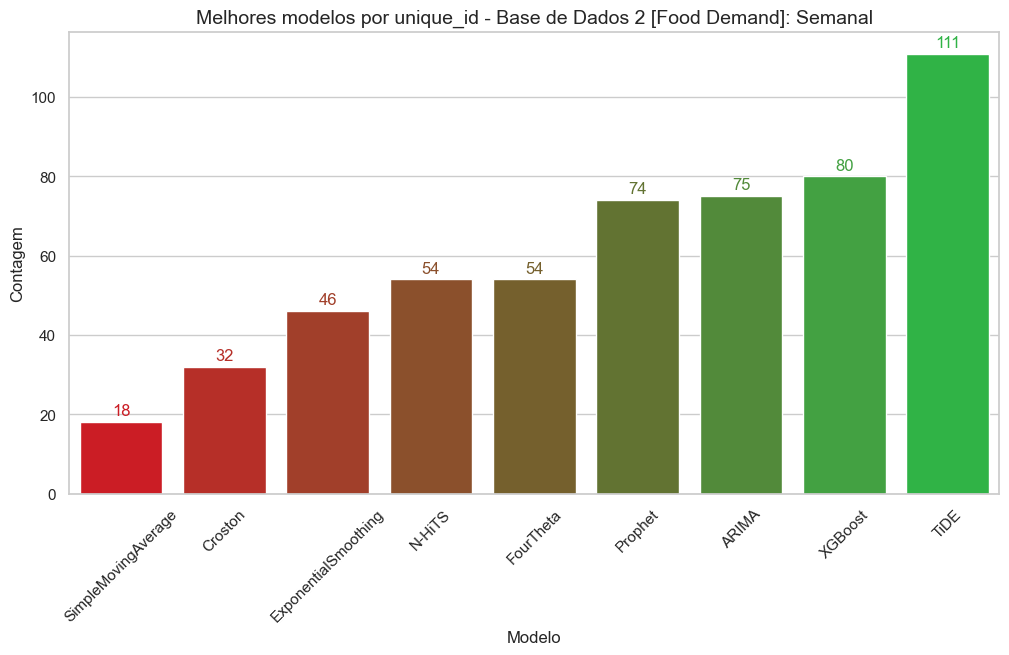

In [67]:
palette = sns.blend_palette(
    [
        get_palette_color(palette="bright", color="red"),
        get_palette_color(palette="bright", color="green")
    ], n_colors=len(food_best_models_vc)
)

adjusted_barplot(
    data=food_best_models_vc.sort("count"), x="model", y="count", hue="model", xlabel="Modelo", ylabel="Contagem", y_is_count=True,
    legend=False, palette=palette, title_size=14, title="Melhores modelos por unique_id - Base de Dados 2 [Food Demand]: Semanal", 
)

In [68]:
food_best_models_vc_percent = food_best_models_vc.with_columns(
    count_percent=(pl.col("count") / pl.sum("count")).round(4)
)

food_best_models_vc_percent.sort("count_percent")

model,count,count_percent
str,u32,f64
"""SimpleMovingAv…",18,0.0331
"""Croston""",32,0.0588
"""ExponentialSmo…",46,0.0846
"""N-HiTS""",54,0.0993
"""FourTheta""",54,0.0993
"""Prophet""",74,0.136
"""ARIMA""",75,0.1379
"""XGBoost""",80,0.1471
"""TiDE""",111,0.204


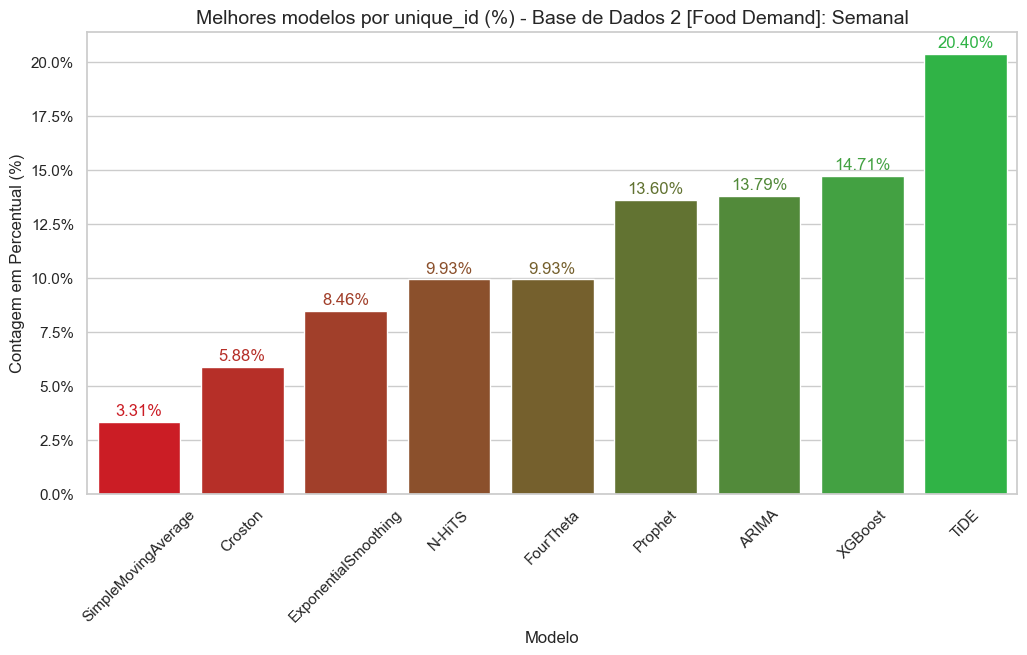

In [69]:
palette = sns.blend_palette(
    [
        get_palette_color(palette="bright", color="red"),
        get_palette_color(palette="bright", color="green")
    ], n_colors=len(food_best_models_vc_percent)
)

adjusted_barplot(
    data=food_best_models_vc_percent.sort("count_percent"), x="model", y="count_percent", hue="model", xlabel="Modelo", ylabel="Contagem em Percentual (%)", 
    y_is_percent=True, legend=False, palette=palette, title_size=14, title="Melhores modelos por unique_id (%) - Base de Dados 2 [Food Demand]: Semanal", 
)

- Diferentemente da Base de Dados 1 [Store Item Demand], o modelo que teve a melhor performance em mais casos foi o *TiDE*, sendo selecionado em 111 casos (20,40%). O *XGBoost*, que foi o mais selecionado na base "Store Item Demand", foi selecionado em 80 casos (14,71%). Os modelos *ARIMA* e *Prophet*, que apresentaram as melhores métricas, foram selecionados em 75 (13,79%) e 74 (13,60%) casos, respectivamente. O *N-HiTS*, com as piores métricas, e o *FourTheta* foram selecionados em 54 casos cada (9,93% cada). O *ExponentialSmoothing* e o *Croston* (modelo para demandas intermitentes) foram selecionados em 46 (8,46%) e 32 (5,88%) casos, respectivamente. Por fim, o *S.M.A.*, apesar de ser o mais rápido, foi selecionado em apenas 18 casos (3,31%).